# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#load-and-normalize-cifar10)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
# pixel color normalize stats per ImageNet dataset specification, same values for train and test.
pixel_mean = [0.5, 0.5, 0.5]
pixel_std = [0.5, 0.5, 0.5]
img_crop_size = 32
img_side_px = 32
rotation=30
batch_size=1000

# we wanted to create random transforms for the training set
# and then use a different transform for both the validation and training sets
# that turned out to be difficult, so we use the same transform appropriate for all three,
# and we do not do random processing on the training data for now.
shared_transforms = transforms.Compose([
    transforms.Resize(img_side_px),
    transforms.CenterCrop(img_crop_size),
    transforms.ToTensor(),
    transforms.Normalize(pixel_mean, pixel_std)
])


train_transform = shared_transforms
# TODO: evaluate options for randomizing input
# transforms.Compose([
#     transforms.RandomRotation(rotation),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(pixel_mean, pixel_std)
# ])
#validation_transforms = shared_transforms

test_transforms = shared_transforms

# Create training set and define training dataloader
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

# split out some validation data from the training set
validation_size = 0.2
num_samples = len(cifar_trainset)
num_validation = int(validation_size * num_samples)
num_train = num_samples - num_validation
trainset, validationset = torch.utils.data.random_split(cifar_trainset, [num_train, num_validation])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])

        fig, axarr = plt.subplots(1, 2)

        image_normalized = images[i].numpy()
        axarr[0].imshow(image_normalized.T)

        # from pytorch.org cifar10 docs
        image_unnormal = images[i] / 2 + 0.5
        image_unnormal = image_unnormal.numpy()
        axarr[1].imshow(image_unnormal.T)
    
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].


frog


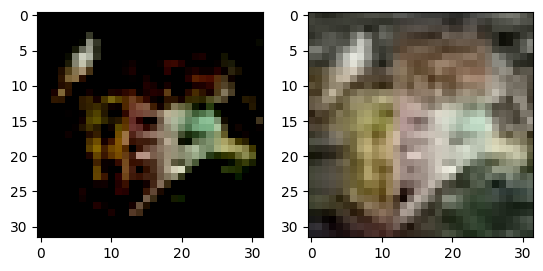

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


car


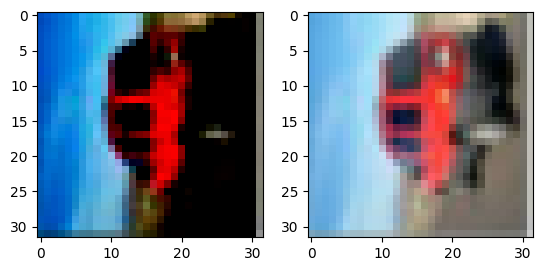

dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


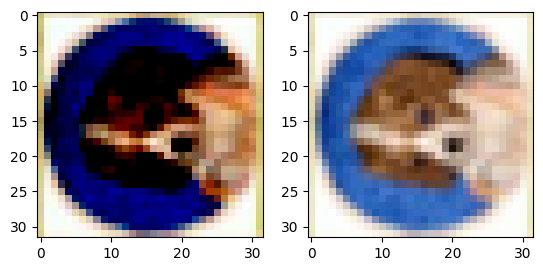

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.99215686].


dog


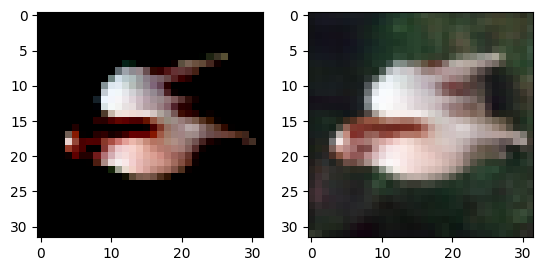

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..1.0].


frog


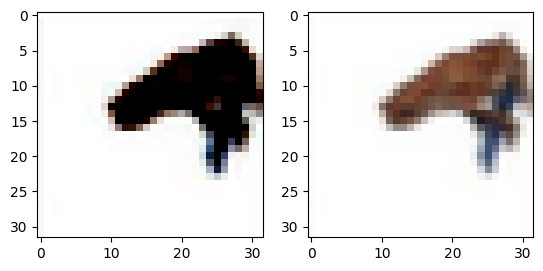

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


cat


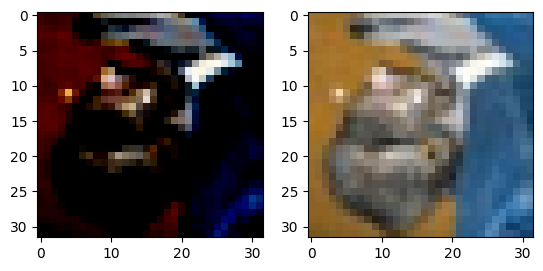

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


ship


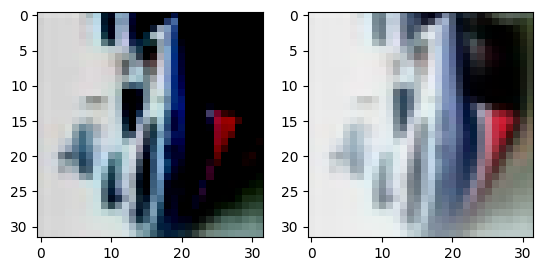

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].


ship


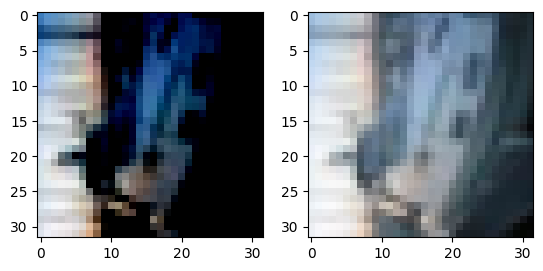

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].


plane


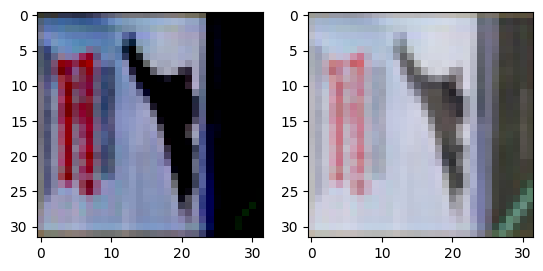

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


frog


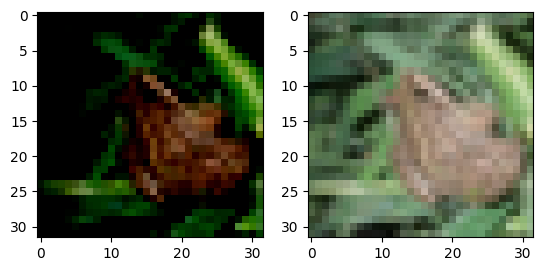

In [4]:
# Explore data
show5(trainloader) # images are shuffled and different each run
show5(testloader)  # images are same for each run

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [24]:

class MyModel(nn.Module):
    def __init__(self, input_count=1024, output_count=10):
        super(MyModel, self).__init__()
        
        # from the pytorch tutorial
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

        # starting with layers derived from VGG
        self.fc1 = nn.Linear(in_features=3072, out_features=1024, bias=True)
        self.fc2 = nn.Linear(in_features=1024, out_features=4096, bias=True)
        self.fc3 = nn.Linear(in_features=4096, out_features=2048, bias=True)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, output_count)

    def forward(self, x):
        # from the pytorch tutorial
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x


        x = F.dropout(F.relu(self.fc1(x)), p=0.5)
        x = F.dropout(F.relu(self.fc2(x)), p=0.2)
        x = F.dropout(F.relu(self.fc3(x)), p=0.2)
        x = F.dropout(F.relu(self.fc4(x)), p=0.2)
        x = F.log_softmax(self.fc5(x), dim=1)
        return x



Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [25]:
# input count is the size of an image
input_count = img_side_px * img_side_px
model = MyModel(input_count=input_count, output_count=len(classes))

def produce_optimizer(parameters, learn_rate):
    return optim.Adam(parameters, lr=learn_rate)

criterion = nn.NLLLoss()

default_learn_rate = 0.001
optimizer = produce_optimizer(parameters=model.parameters(), learn_rate=default_learn_rate)


Define a helper function to help track and record accuracy and loss.

In [26]:
# evaluate the model on the specified dataloader using the crierion

def check_accuracy(model, criterion, dataloader, device=None):
    loss = 0
    accuracy = 0

    if not device:
        device_name = "cuda" if torch.cuda.is_available() else "cpu"
        device = torch.device(device_name)
    model.to(device)

    # turn off training
    model.eval()

    # disable gradient tracking during evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # run the model on a batch
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            # capture statistics
            loss += batch_loss.item()
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()

    loss = loss/len(dataloader)
    accuracy = accuracy/len(dataloader)

    return loss, accuracy


def print_metrics_record(record):
    type = record['type']
    if type == 'eval':
        print((
            f"{type}: id={record['epoch']}-{record['batch']}  " 
            f"validation_accuracy={record['validation_accuracy']:.2f}  " 
            f"validation_loss={record['validation_loss']:.2f}  "
            f"training_loss={record['training_loss']:.2f}  "
        ))
    elif type == 'batch':
        print(f"{type}")
    elif type == 'epoch':
        print(f"{type}")

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [29]:
epochs = 5
# how many batches are procesed before we print a summary
# each batch represents training on "batch_size" images
print_every = 1

device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
model.to(device)
print(f"Training device: {device_name}")

# we keep track of training stats as records in a metrics array 
# so we cah show summaries after training
metrics = []
def produce_metrics_record(type, epoch):
    return {
        'type': type,
        'running_loss': 0, 
        'epoch': epoch
    }

learn_rate = default_learn_rate
for epoch in range(epochs):
    running_loss = 0
    epoch_record = produce_metrics_record(type='epoch', epoch=epoch)
    if epoch > 0:
        learn_rate = learn_rate / 4
        print(f"Updated learn_rate: {learn_rate}")
    optimizer = produce_optimizer(parameters=model.parameters(), learn_rate=learn_rate)
    for batch_count, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        
        batch_record = produce_metrics_record(type='batch', epoch=epoch)
        batch_record['batch'] = batch_count
        
        optimizer.zero_grad()

        # capture probabilities in forward step
        logps = model.forward(inputs)
        loss = criterion(logps, labels)

        loss.backward()

        # update parameters with lessons learned
        optimizer.step()

        # track loss over many batches
        running_loss += loss.item()
        batch_record['running_loss'] = running_loss
        metrics.append(batch_record)

        # every few batches evaluate performance and print metrics
        if batch_count > 0 and batch_count % print_every == 0:
            eval_record = produce_metrics_record(type='eval', epoch=epoch)
            eval_record['batch'] = batch_count
            eval_record['training_loss'] = running_loss / (batch_count + 1)
            validation_loss, validation_accuracy = check_accuracy(model=model, criterion=criterion, dataloader=validationloader, device=device)
            eval_record['validation_loss'] = validation_loss
            eval_record['validation_accuracy'] = validation_accuracy
            metrics.append(eval_record)
            
            print_metrics_record(eval_record)
            
    metrics.append(epoch_record)





Training device: cuda
eval: id=0-1  validation_accuracy=0.35  validation_loss=1.93  training_loss=1.53  
eval: id=0-2  validation_accuracy=0.35  validation_loss=1.85  training_loss=1.65  
eval: id=0-3  validation_accuracy=0.38  validation_loss=1.75  training_loss=1.68  
eval: id=0-4  validation_accuracy=0.40  validation_loss=1.74  training_loss=1.69  
eval: id=0-5  validation_accuracy=0.39  validation_loss=1.72  training_loss=1.70  
eval: id=0-6  validation_accuracy=0.38  validation_loss=1.72  training_loss=1.69  
eval: id=0-7  validation_accuracy=0.40  validation_loss=1.69  training_loss=1.68  
eval: id=0-8  validation_accuracy=0.41  validation_loss=1.68  training_loss=1.68  
eval: id=0-9  validation_accuracy=0.42  validation_loss=1.69  training_loss=1.68  
eval: id=0-10  validation_accuracy=0.41  validation_loss=1.67  training_loss=1.68  
eval: id=0-11  validation_accuracy=0.41  validation_loss=1.65  training_loss=1.67  
eval: id=0-12  validation_accuracy=0.42  validation_loss=1.64  

Plot the training loss (and validation loss/accuracy, if recorded).

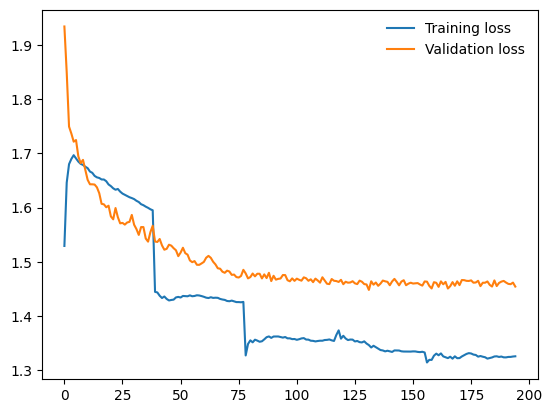

In [30]:
train_losses = [m['training_loss'] for m in metrics if m['type'] == 'eval']
validation_losses = [m['validation_loss'] for m in metrics if m['type'] == 'eval']

# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**

